**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2024**

---

### **Introducción al Aprendizaje Profundo 2024**
### Redes Convolucionales

---

In [5]:
# Importando líbrerias
import time
import platform
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

import optuna
import torch
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor, transforms
from torchvision.utils import make_grid

# Configuración de la semilla
seed = 27
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

# Configura matplotlib para renderizar gráficos en línea en la celda de salida
%matplotlib inline

In [2]:
# Dispositivo y versiones 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device:\t{device}')
print(f'Python:\t{platform.python_version()}')
print(f'Torch:\t{torch.__version__}')

Device:	cpu
Python:	3.11.4
Torch:	2.4.1


## 1. Procesamiento de imágenes

El dataset consiste en un conjunto de datos para 100 especies de mariposas y polillas. Todas las imágenes estan .jpg y tienen un tamaño de 224 x 224 x 3. Esta dividido en *train*, *valid* y *test*. 

La función `data_preparation` se encarga de preparar los datos de entrenamiento, validación y prueba para los modelos. Carga los datos a partir de la ruta específica mediante la clase `ImageFolder`. Luego se crean los `DataLoader` para cada conjunto de datos.

In [3]:
def data_preparation(BATCH_SIZE, PATH, transform):

    # Datos de entrenamiento
    train_set = torchvision.datasets.ImageFolder(root=f'{PATH}/train', transform=transform)
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

    # Datos de validación 
    val_set = torchvision.datasets.ImageFolder(root=f'{PATH}/valid', transform=transform)
    val_loader = torch.utils.data.DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    # Datos de test 
    test_set = torchvision.datasets.ImageFolder(root=f'{PATH}/test', transform=transform)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

    return train_set, train_loader, val_set, val_loader, test_set, test_loader

#='../Data/butterflies_moths_dataset

Se define la transformación de los datos para luego prepararlos: 
- Redomensinar las imágenes
- Transformar los datos a tensores
- Normalizar los valores a un valor medio igual a 0.5

Luego se obtienen las clases de los datos, para este caso, corresponde con el nombre de las mariposas.

In [44]:
BATCH_SIZE = 64
PATH = '../Data/butterflies_moths_dataset'

# Definir las transformaciones para las imágenes
transform = transforms.Compose([
    transforms.Resize((28, 28)),  
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  
])

# Preparar los datasets y loaders
train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, PATH, transform)

# Obtener las clases (carpetas de especies)
classes = train_set.classes
print(f'Classes: {classes}')

Classes: ['ADONIS', 'AFRICAN GIANT SWALLOWTAIL', 'AMERICAN SNOOT', 'AN 88', 'APPOLLO', 'ARCIGERA FLOWER MOTH', 'ATALA', 'ATLAS MOTH', 'BANDED ORANGE HELICONIAN', 'BANDED PEACOCK', 'BANDED TIGER MOTH', 'BECKERS WHITE', 'BIRD CHERRY ERMINE MOTH', 'BLACK HAIRSTREAK', 'BLUE MORPHO', 'BLUE SPOTTED CROW', 'BROOKES BIRDWING', 'BROWN ARGUS', 'BROWN SIPROETA', 'CABBAGE WHITE', 'CAIRNS BIRDWING', 'CHALK HILL BLUE', 'CHECQUERED SKIPPER', 'CHESTNUT', 'CINNABAR MOTH', 'CLEARWING MOTH', 'CLEOPATRA', 'CLODIUS PARNASSIAN', 'CLOUDED SULPHUR', 'COMET MOTH', 'COMMON BANDED AWL', 'COMMON WOOD-NYMPH', 'COPPER TAIL', 'CRECENT', 'CRIMSON PATCH', 'DANAID EGGFLY', 'EASTERN COMA', 'EASTERN DAPPLE WHITE', 'EASTERN PINE ELFIN', 'ELBOWED PIERROT', 'EMPEROR GUM MOTH', 'GARDEN TIGER MOTH', 'GIANT LEOPARD MOTH', 'GLITTERING SAPPHIRE', 'GOLD BANDED', 'GREAT EGGFLY', 'GREAT JAY', 'GREEN CELLED CATTLEHEART', 'GREEN HAIRSTREAK', 'GREY HAIRSTREAK', 'HERCULES MOTH', 'HUMMING BIRD HAWK MOTH', 'INDRA SWALLOW', 'IO MOTH', 'Ip

Se visualizan las imágenes de entrenamiento en un lote. Las imágenes se ven más oscuras, esto se debe a que la normalización modificó los niveles de RGB, desplazándolos fuera del rango de 0.0 a 1.0 y alterando las magnitudes de los canales. Aunque todos los datos siguen estando presentes, Matplotlib los representa como negro.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


images.shape: torch.Size([64, 3, 28, 28])


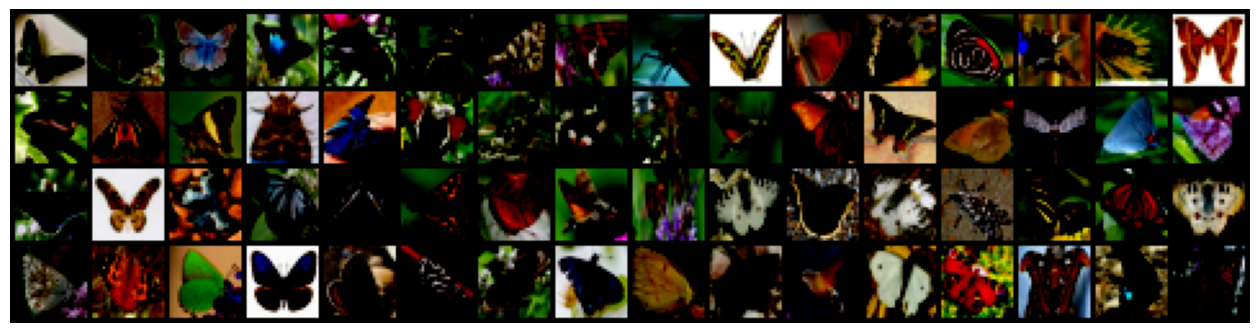

In [5]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

### Funciones útiles

La función `train_val` se encarga de entrenar el modelo durante un número determinado de épocas y devuelve un diccionario con los resultados del experimiento, incluyendo la pérdida y la precisión en cada época. La función `plot_loss_and_accuracy` crea un gráfico que muestra la pérdida y la precisión a lo largo de cada época. `print_model_info` muestra los parámetros del modelo.

In [15]:
def train_val(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    # Ciclo for para el número de épocas
    train_loss_history, train_acc_history, val_loss_history, val_acc_history = [], [], [], []
    all_labels, all_preds = [], []
    model = model.to(device=device)

    for epoch in range(num_epochs):
        train_loss, train_acc, val_loss, val_acc = 0, 0, 0, 0

        # Establecer el modelo en modo de entrenamiento
        model.train()
        y_true_train, y_pred_train = [], []

        # Iterar sobre los datos de entrenamiento
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
            optimizer.zero_grad()
            predicted_outputs = model(inputs)
            # Calcular la pérdida
            loss = criterion(predicted_outputs, labels)
            loss.backward()
            optimizer.step()
            # Acumular la pérdida y la precisión
            train_loss += loss.item()
            # La etiqueta con mayor valor será nuestra predicción
            _, predicted = torch.max(predicted_outputs , 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio del entrenamiento
        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_acc_history.append(train_acc)

        # Establecer el modelo en modo de evalución
        model.eval()
        y_true_test, y_pred_test = [], []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.long)
                predicted_outputs = model(inputs)
                # Calcular la pérdida
                loss = criterion(predicted_outputs, labels)
                # Acumular la pérdida
                val_loss += loss.item()
                # La etiqueta con mayor valor será nuestra predicción
                _, predicted = torch.max(predicted_outputs , 1)
                y_true_test.extend(labels.cpu().numpy())
                y_pred_test.extend(predicted.cpu().numpy())

        # Calcular la pérdida y precisión promedio
        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)
        val_acc = accuracy_score(y_true_test, y_pred_test)
        val_acc_history.append(val_acc)
        all_labels.extend(y_true_test)
        all_preds.extend(y_pred_test)

        print(f'Epoch {epoch+1}/{num_epochs}\tTrain Loss: {train_loss:.3f}   Train Acc: {train_acc:.3f}   Val Loss: {val_loss:.3f}   Val Acc: {val_acc:.3f}')

    experiment = {
        'epoch_training_loss': train_loss_history,
        'training_accuracy': train_acc_history,
        'epoch_validation_loss': val_loss_history,
        'validation_accuracy': val_acc_history
    }
    experiment['epoch'] = list(range(num_epochs))

    return experiment, all_labels, all_preds


def plot_loss_and_accuracy(experiment, title=None):
  df_experiment = pd.DataFrame(experiment)

  fig, axs = plt.subplots(1, 2, figsize=(15, 4))
  sns.lineplot(data=df_experiment, x='epoch', y='epoch_training_loss', label='Entrenamiento', marker='.', markeredgecolor='none' ,ax=axs[0], color='dodgerblue')
  sns.lineplot(data=df_experiment, x='epoch', y='epoch_validation_loss', label='Validación', marker='.', markeredgecolor='none', ax=axs[0], color='firebrick')
  plt.grid(alpha=0.5)
  sns.lineplot(data=df_experiment, x='epoch', y='training_accuracy', label='Entrenamiento', marker='.', markeredgecolor='none', ax=axs[1], color='dodgerblue')
  sns.lineplot(data=df_experiment, x='epoch', y='validation_accuracy', label='Validación', marker='.', markeredgecolor='none', ax=axs[1], color='firebrick')
  for i, ax in enumerate(axs.ravel()):
      #print(i)
      ax.set_xlabel('Época')
      if i < 1:
        ax.set_ylabel('Pérdida')
      else:
        ax.set_ylabel('Precisión (Accuracy)')
      ax.legend()
      ax.grid(alpha=0.5)

  plt.suptitle(title)
  plt.show()


def print_model_info(model):
    # Obtener los parámetros del modelo
    params = model.state_dict()

    # Imprimir las dimensiones de las capas
    print('Dimensiones de las capas:')
    for name, param in model.named_parameters():
        print(f'\t{name}: {param.shape}')

    # Imprimir la cantidad de parámetros
    print('Cantidad de parámetros:')
    for key, value in params.items():
        print(f'\t{key}: {torch.numel(value)}')

    # Imprimir el modelo
    print(f'Modelo: {model}')

## 2. Baseline

La red neuronal convolucional tiene dos capas convolucionales de 10 y 20 canales, con filtro de 5x5 y no aplica relleno a la entrada. Seguido de dos capas de pooling máximo y una capa fully connected. La función de activación ReLU se aplica después de cada capa convolucional.

In [17]:
class NetCNN(nn.Module):
    def __init__(self):
        super(NetCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=10, kernel_size=5, padding=0)
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, padding=0)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(2, 2)
        self.fc = nn.Linear(4 * 4 * 20, 100)


    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, self.fc.in_features)
        return self.fc(x)

La función de pérdida es por entropía cruzada y el optimizador SGD

In [13]:
num_epochs = 15 # Originalmente era 30, pero la validación se estabilizaba cerca de 15

model_baseline = NetCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_baseline.parameters(), lr=1e-2, weight_decay=0.001, momentum=0.9)

experiment_baseline, all_labels_baseline, all_preds_baseline = train_val(model_baseline, criterion, optimizer, train_loader, val_loader, num_epochs)
torch.save(model_baseline, 'model_baseline.pth')

Epoch 1/15	Train Loss: 4.232   Train Acc: 0.050   Val Loss: 3.597   Val Acc: 0.120
Epoch 2/15	Train Loss: 3.209   Train Acc: 0.220   Val Loss: 2.765   Val Acc: 0.306
Epoch 3/15	Train Loss: 2.527   Train Acc: 0.376   Val Loss: 2.297   Val Acc: 0.456
Epoch 4/15	Train Loss: 2.137   Train Acc: 0.464   Val Loss: 1.987   Val Acc: 0.490
Epoch 5/15	Train Loss: 1.862   Train Acc: 0.520   Val Loss: 1.830   Val Acc: 0.526
Epoch 6/15	Train Loss: 1.648   Train Acc: 0.572   Val Loss: 1.745   Val Acc: 0.576
Epoch 7/15	Train Loss: 1.511   Train Acc: 0.594   Val Loss: 1.653   Val Acc: 0.594
Epoch 8/15	Train Loss: 1.380   Train Acc: 0.629   Val Loss: 1.643   Val Acc: 0.594
Epoch 9/15	Train Loss: 1.258   Train Acc: 0.662   Val Loss: 1.663   Val Acc: 0.586
Epoch 10/15	Train Loss: 1.167   Train Acc: 0.684   Val Loss: 1.656   Val Acc: 0.604
Epoch 11/15	Train Loss: 1.080   Train Acc: 0.702   Val Loss: 1.618   Val Acc: 0.604
Epoch 12/15	Train Loss: 1.023   Train Acc: 0.716   Val Loss: 1.707   Val Acc: 0.602
E

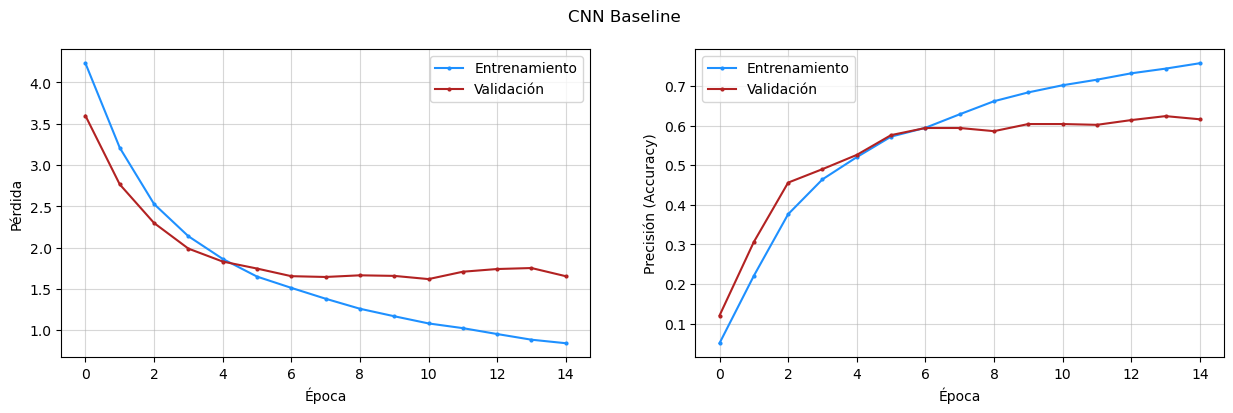

In [14]:
plot_loss_and_accuracy(experiment_baseline, title='CNN Baseline')

In [16]:
print_model_info(model_baseline)

Dimensiones de las capas:
	conv1.weight: torch.Size([10, 3, 5, 5])
	conv1.bias: torch.Size([10])
	conv2.weight: torch.Size([20, 10, 5, 5])
	conv2.bias: torch.Size([20])
	fc.weight: torch.Size([100, 320])
	fc.bias: torch.Size([100])
Cantidad de parámetros:
	conv1.weight: 750
	conv1.bias: 10
	conv2.weight: 5000
	conv2.bias: 20
	fc.weight: 32000
	fc.bias: 100
Modelo: NetCNNwithoutPadding(
  (conv1): Conv2d(3, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (relu): ReLU()
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc): Linear(in_features=320, out_features=100, bias=True)
)


## 3. Busqueda de mejores resultados

### Ajuste de hiperparámetros con Optuma

Partiendo del modelo baseline, se realiza una busqueda de hiperparámetros para obtener mejores resultados. Mediante `optuma` se buscan tres hiperparámetros: 
- Tasa de aprendizaje: busca entre un rango logarítmico de 1e-4 a 1e-2
- Optimizador: Adam, AdamW y RMSprop
- Tamaño de lote: 128 y 256

In [24]:
def objective(trial):
    lr = trial.suggest_float('lr', 1e-4, 1e-2, log=True)
    optimizer_name = trial.suggest_categorical('optimizer', ['Adam', 'AdamW', 'RMSprop'])
    BATCH_SIZE = trial.suggest_categorical('batch_size', [128, 256])
    PATH = '../Data/butterflies_moths_dataset'

    # Cargar los datos
    train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, PATH, transform)
    
    # Crear el modelo
    model = NetCNN()
    
    # Elegir el optimizador
    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr)
    else:
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

    # Definir la pérdida
    criterion = nn.CrossEntropyLoss()

    # Entrenamiento
    model.train()
    for epoch in range(15):  # Ajusta el número de épocas según sea necesario
        running_loss = 0.0
        for i, (inputs, labels) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 100 == 99:  # Imprimir cada 100 lotes
                print(f'Epoch {epoch+1}, Batch {i+1}, Loss: {running_loss / 100}')
                running_loss = 0.0

    # Validación
    model.eval()
    total, correct = 0, 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy

# Configuración de la búsqueda con Optuna
study = optuna.create_study(study_name='cnn_hyperparameter_tuning', direction='maximize')  # Maximizar la precisión
study.optimize(objective, n_trials=20)  # Ejecutar 20 pruebas

# Imprimir los mejores hiperparámetros
print(f"Mejores hiperparámetros: {study.best_params}")


[I 2024-10-11 15:17:29,578] A new study created in memory with name: cnn_hyperparameter_tuning
[I 2024-10-11 15:21:29,187] Trial 0 finished with value: 0.188 and parameters: {'lr': 0.0007171207861260924, 'optimizer': 'AdamW', 'batch_size': 128}. Best is trial 0 with value: 0.188.
[I 2024-10-11 15:25:22,437] Trial 1 finished with value: 0.512 and parameters: {'lr': 0.00046720822471934994, 'optimizer': 'Adam', 'batch_size': 128}. Best is trial 1 with value: 0.512.
[I 2024-10-11 15:29:15,583] Trial 2 finished with value: 0.282 and parameters: {'lr': 0.001054892015892266, 'optimizer': 'RMSprop', 'batch_size': 128}. Best is trial 1 with value: 0.512.
[I 2024-10-11 15:33:08,359] Trial 3 finished with value: 0.026 and parameters: {'lr': 0.00026061073903188917, 'optimizer': 'AdamW', 'batch_size': 256}. Best is trial 1 with value: 0.512.
[I 2024-10-11 15:37:00,000] Trial 4 finished with value: 0.4 and parameters: {'lr': 0.004637885077301658, 'optimizer': 'AdamW', 'batch_size': 256}. Best is tri

Mejores hiperparámetros: {'lr': 0.005726998510310945, 'optimizer': 'Adam', 'batch_size': 256}


De esta manera se obtiene que los mejores hiperparámetros son: 
- Tasa de aprendizaje: 0.005726998510310945
- Optimizador: Adam
- Tamaño de lote: 256

Una vez encontrados los parámetros, se vuelve a entrenar el modelo, aumentando el número de épocas a 20

In [45]:
num_epochs = 15
BATCH_SIZE = 256

model_hyper = NetCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_hyper.parameters(), lr=0.005726998510310945)

train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, PATH, transform)

experiment_hyper, all_labels_hyper, all_preds_hyper = train_val(model_hyper, criterion, optimizer, train_loader, val_loader, num_epochs)
torch.save(model_hyper, 'model_hyper.pth')

Epoch 1/20	Train Loss: 3.562   Train Acc: 0.153   Val Loss: 2.767   Val Acc: 0.286
Epoch 2/20	Train Loss: 2.499   Train Acc: 0.376   Val Loss: 2.150   Val Acc: 0.458
Epoch 3/20	Train Loss: 2.008   Train Acc: 0.491   Val Loss: 1.883   Val Acc: 0.558
Epoch 4/20	Train Loss: 1.714   Train Acc: 0.557   Val Loss: 1.764   Val Acc: 0.578
Epoch 5/20	Train Loss: 1.501   Train Acc: 0.608   Val Loss: 1.793   Val Acc: 0.574
Epoch 6/20	Train Loss: 1.358   Train Acc: 0.639   Val Loss: 1.726   Val Acc: 0.590
Epoch 7/20	Train Loss: 1.245   Train Acc: 0.662   Val Loss: 1.640   Val Acc: 0.600
Epoch 8/20	Train Loss: 1.129   Train Acc: 0.694   Val Loss: 1.728   Val Acc: 0.628
Epoch 9/20	Train Loss: 1.046   Train Acc: 0.711   Val Loss: 1.814   Val Acc: 0.612
Epoch 10/20	Train Loss: 0.966   Train Acc: 0.728   Val Loss: 1.766   Val Acc: 0.614
Epoch 11/20	Train Loss: 0.886   Train Acc: 0.755   Val Loss: 1.779   Val Acc: 0.604
Epoch 12/20	Train Loss: 0.831   Train Acc: 0.762   Val Loss: 1.851   Val Acc: 0.608
E

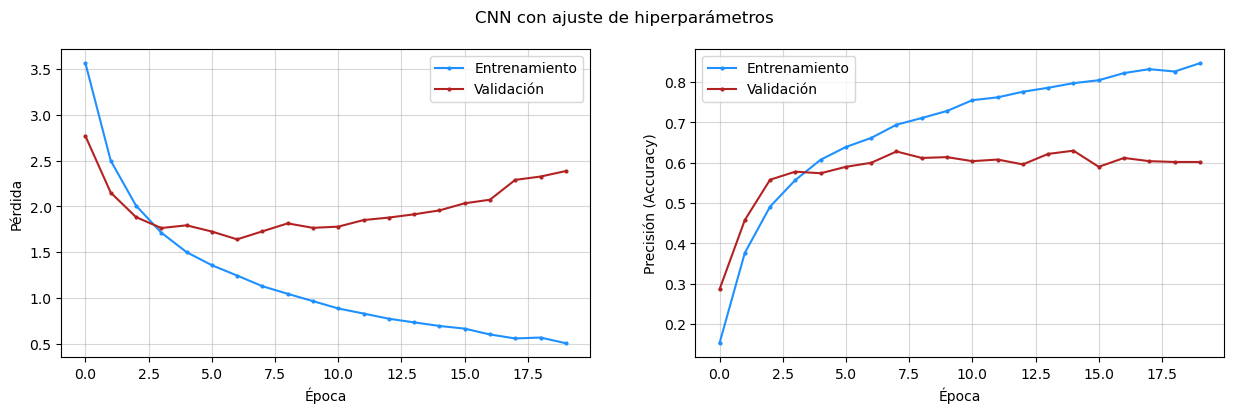

In [49]:
plot_loss_and_accuracy(experiment_hyper, title='CNN con ajuste de hiperparámetros')

### Transfer Learning ResNet18

El Transfer Learning es una técnica que permite utilizar un modelo preentrenado en un problema especifico. [Resnet18](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html) es un modelo que cuenta con 18 capas de convolución. El modelo se entrenó originalmente en el conjunto de datos ImageNet, que contiene más de 14 millones de imágenes de 21.841 categorías. El modelo se entrenó para predecir la categoría de una imagen dada.

Se realiza la siguiente transformación de las imágenes:
- Redimensiona las imágenes a un tamaño de 256 x 256
- Extrae un cuadrado central de la imagen de tamaño 224 x 224
- Convierte a tensores
- Normaliza las imágenes utilizando los valores medios y desviaciones estándar

In [30]:
BATCH_SIZE = 64

transform = transforms.Compose([transforms.Resize(256),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

train_set, train_loader, val_set, val_loader, test_set, test_loader = data_preparation(BATCH_SIZE, PATH, transform)

In [32]:
# Cargar el modelo preentrenado
model_rn18 = torchvision.models.resnet18(pretrained=True)
print(f'Modelo: {model_rn18}')

Modelo: ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\enzom\miniconda3\envs\env_1\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [33]:
# Explorar las capas del modelo
for i, w in enumerate(model_rn18.parameters()):
    print(i+1, w.shape, w.requires_grad)

1 torch.Size([64, 3, 7, 7]) True
2 torch.Size([64]) True
3 torch.Size([64]) True
4 torch.Size([64, 64, 3, 3]) True
5 torch.Size([64]) True
6 torch.Size([64]) True
7 torch.Size([64, 64, 3, 3]) True
8 torch.Size([64]) True
9 torch.Size([64]) True
10 torch.Size([64, 64, 3, 3]) True
11 torch.Size([64]) True
12 torch.Size([64]) True
13 torch.Size([64, 64, 3, 3]) True
14 torch.Size([64]) True
15 torch.Size([64]) True
16 torch.Size([128, 64, 3, 3]) True
17 torch.Size([128]) True
18 torch.Size([128]) True
19 torch.Size([128, 128, 3, 3]) True
20 torch.Size([128]) True
21 torch.Size([128]) True
22 torch.Size([128, 64, 1, 1]) True
23 torch.Size([128]) True
24 torch.Size([128]) True
25 torch.Size([128, 128, 3, 3]) True
26 torch.Size([128]) True
27 torch.Size([128]) True
28 torch.Size([128, 128, 3, 3]) True
29 torch.Size([128]) True
30 torch.Size([128]) True
31 torch.Size([256, 128, 3, 3]) True
32 torch.Size([256]) True
33 torch.Size([256]) True
34 torch.Size([256, 256, 3, 3]) True
35 torch.Size([2

In [35]:
# Seleccionar las capas que no se van a entrenar

model_fit_rn18 = nn.Sequential(*list(model_rn18.children())[:-1])  # Selecciona todas las capas excepto la última
model_fit_rn18

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [36]:
# Congelar todas las capas excepto la última, para que no se entrenen
for param in model_fit_rn18.parameters():
    param.requires_grad = False

# Agregar la capa de salida ajustada a nuestra salida y entrenar
model_fitted_resnet18 = nn.Sequential(
                            model_fit_rn18,
                            nn.Flatten(),   # aplana la salida obtenida de la capa anterior
                            # el valor 512 es el número de canales de la última capa convolucional
                            nn.Linear(in_features=512, out_features=100, bias=True))
model_fitted_resnet18

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [37]:
# Explorar las capas del modelo
for i, w in enumerate(model_fitted_resnet18.parameters()):
    print(i+1, w.shape, w.requires_grad)

1 torch.Size([64, 3, 7, 7]) False
2 torch.Size([64]) False
3 torch.Size([64]) False
4 torch.Size([64, 64, 3, 3]) False
5 torch.Size([64]) False
6 torch.Size([64]) False
7 torch.Size([64, 64, 3, 3]) False
8 torch.Size([64]) False
9 torch.Size([64]) False
10 torch.Size([64, 64, 3, 3]) False
11 torch.Size([64]) False
12 torch.Size([64]) False
13 torch.Size([64, 64, 3, 3]) False
14 torch.Size([64]) False
15 torch.Size([64]) False
16 torch.Size([128, 64, 3, 3]) False
17 torch.Size([128]) False
18 torch.Size([128]) False
19 torch.Size([128, 128, 3, 3]) False
20 torch.Size([128]) False
21 torch.Size([128]) False
22 torch.Size([128, 64, 1, 1]) False
23 torch.Size([128]) False
24 torch.Size([128]) False
25 torch.Size([128, 128, 3, 3]) False
26 torch.Size([128]) False
27 torch.Size([128]) False
28 torch.Size([128, 128, 3, 3]) False
29 torch.Size([128]) False
30 torch.Size([128]) False
31 torch.Size([256, 128, 3, 3]) False
32 torch.Size([256]) False
33 torch.Size([256]) False
34 torch.Size([256, 

Se filtran los parámetros del modelo para asegurarse de que solo aquellos que tienen `requires_grad=True` sean optimizados. El atributo `requires_grad` indica si un tensor necesita calcular gradientes, y por lo tanto, ser ajustado durante el entrenamiento. Esto se debe a que en redes preentrenadas, no se desea modificar ciertos parámetros.

In [38]:
# Entrenar la última capa del modelo
num_epochs = 15
model_tl_rn18 = model_fitted_resnet18
optimizer = torch.optim.SGD(filter(lambda p: p.requires_grad, model_tl_rn18.parameters()), lr=0.001, momentum=0.9)

experiment_tl_rn18, all_labels_tl_rn18, all_preds_tl_rn18 = train_val(model_tl_rn18, criterion, optimizer, train_loader, val_loader, num_epochs)
torch.save(model_tl_rn18, 'model_tl_rn18.pth') 

Epoch 1/15	Train Loss: 4.152   Train Acc: 0.162   Val Loss: 3.493   Val Acc: 0.420
Epoch 2/15	Train Loss: 3.039   Train Acc: 0.545   Val Loss: 2.525   Val Acc: 0.668
Epoch 3/15	Train Loss: 2.283   Train Acc: 0.708   Val Loss: 1.921   Val Acc: 0.736
Epoch 4/15	Train Loss: 1.804   Train Acc: 0.778   Val Loss: 1.554   Val Acc: 0.780
Epoch 5/15	Train Loss: 1.491   Train Acc: 0.809   Val Loss: 1.307   Val Acc: 0.822
Epoch 6/15	Train Loss: 1.278   Train Acc: 0.831   Val Loss: 1.136   Val Acc: 0.832
Epoch 7/15	Train Loss: 1.126   Train Acc: 0.849   Val Loss: 1.023   Val Acc: 0.838
Epoch 8/15	Train Loss: 1.018   Train Acc: 0.855   Val Loss: 0.929   Val Acc: 0.850
Epoch 9/15	Train Loss: 0.929   Train Acc: 0.865   Val Loss: 0.858   Val Acc: 0.858
Epoch 10/15	Train Loss: 0.860   Train Acc: 0.874   Val Loss: 0.798   Val Acc: 0.866
Epoch 11/15	Train Loss: 0.807   Train Acc: 0.876   Val Loss: 0.754   Val Acc: 0.868
Epoch 12/15	Train Loss: 0.757   Train Acc: 0.881   Val Loss: 0.727   Val Acc: 0.876
E

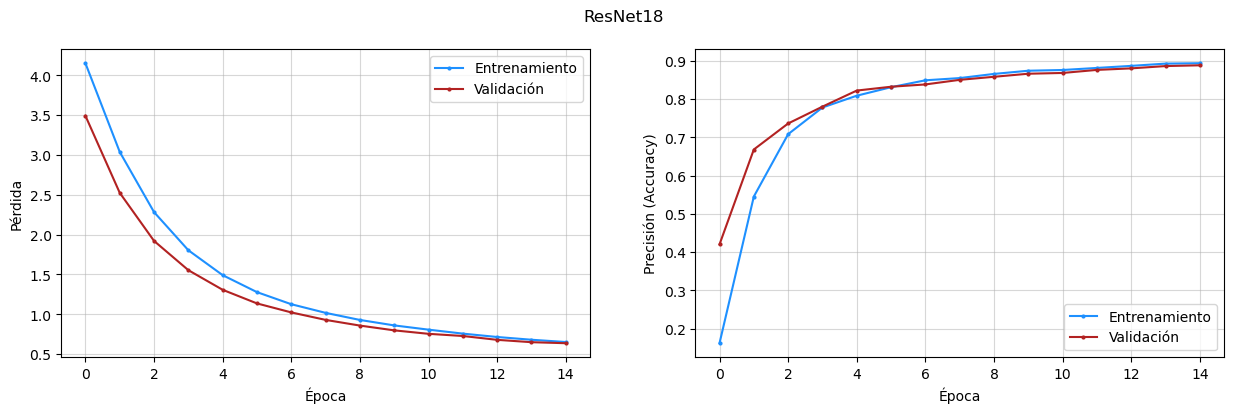

In [40]:
plot_loss_and_accuracy(experiment_tl_rn18, title='ResNet18')

## 4. Conclusión

Se puede concluir con:

- CNN Baseline: La pérdida en el conjunto de entrenamiento disminuye constantemente, sugiere que el modelo está aprendiendo. Sin embargo, la pérdida en el conjunto de validación se estabiliza alrededor de la época 8, y después comienza a aumentar ligeramente. La precisión en el conjunto de entrenamiento mejora progresivamente. Sin embargo, la precisión en el conjunto de validación se estanca alrededor de la época 8, lo que indica un posible sobreajuste a partir de esa época. El modelo tiende a sobreajustar, ya que la pérdida en validación comienza a aumentar después de algunas épocas, mientras que la precisión en validación no sigue mejorando significativamente.


- CNN con ajuste de hiperparámetros: En comparación con CNN Baseline, la pérdida en el conjunto de entrenamiento es menor y disminuye más rápidamente. Sin embargo, la pérdida en validación comienza a aumentar después de la época 5, lo que sugiere sobreajuste a partir de ese punto. La precisión del modelo en entrenamiento aumenta de forma constante. Sin embargo, la precisión en validación también se estabiliza alrededor de la época 5, sin grandes mejoras posteriores. Aunque los ajustes de hiperparámetros parecen mejorar el rendimiento inicial del modelo, el modelo también sufre de sobreajuste, con la pérdida de validación aumentando después de la época 5.

- ResNet18: La pérdida tanto en el conjunto de entrenamiento como en el de validación disminuye de manera constante, con una tendencia más estable. No hay un aumento significativo de la pérdida en validación, lo que sugiere que el modelo generaliza mejor. La precisión en ambos conjuntos mejora significativamente y de manera más estable, alcanzando niveles más altos y manteniéndose cercanos entre el entrenamiento y la validación. Esto indica que ResNet18 tiene un mejor rendimiento en términos de generalización. El modelo muestra el mejor rendimiento entre los tres modelos, con una buena reducción de la pérdida y una mejora constante en la precisión. No muestra signos claros de sobreajuste, lo que sugiere que es más adecuado para este conjunto de datos que la CNN simple, incluso después del ajuste de hiperparámetros.

CNN y CNN con ajuste de hiperparámetros muestran problemas de sobreajuste, con mejoras en la precisión de entrenamiento, pero un estancamiento o incluso aumento en la pérdida de validación después de varias épocas. El modelo ResNet18 se comporta de manera más robusta, manteniendo una mejor generalización sin signos claros de sobreajuste, y parece ser el modelo más adecuado de los tres para este conjunto de datos.

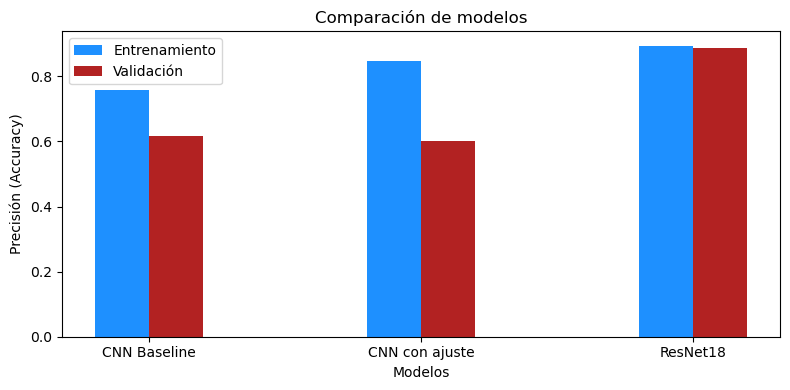

In [70]:
# Crear arrays de datos
models = ['CNN Baseline', 'CNN con ajuste', 'ResNet18']
train_accuracy = [experiment_baseline['training_accuracy'][-1], experiment_hyper['training_accuracy'][-1], experiment_tl_rn18['training_accuracy'][-1]]
val_accuracy = [experiment_baseline['validation_accuracy'][-1], experiment_hyper['validation_accuracy'][-1], experiment_tl_rn18['validation_accuracy'][-1]]

# Configuración del gráfico
x = np.arange(len(models))  # Posiciones en el eje X
width = 0.2 # Ancho de las barras

fig, ax = plt.subplots(figsize=(8, 4))
rects1 = ax.bar(x - width/2, train_accuracy, width, label='Entrenamiento', color='dodgerblue')
rects2 = ax.bar(x + width/2, val_accuracy, width, label='Validación', color='firebrick')

# Añadir etiquetas y título
ax.set_xlabel('Modelos')
ax.set_ylabel('Precisión (Accuracy)')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_title('Comparación de modelos')
ax.legend()
plt.tight_layout()
plt.show()